# Digits classifier

Let's build a model that is able to recognize digits 3 and 7.

In [ ]:
%pip install fastbook

In [8]:
# loading and setting up dependencies
import fastbook

fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

In [9]:
# import MNIST sample that only contains 3s and 7s
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

As you can see from the previous output, this dataset is organized into separate folders for training and validation sets.

In [10]:
# let's see what's inside the training set
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

We are confirming here that the training sample contains 7's and 3's only. These are our _labels_. Let's zoom in a little more.

In [11]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [12]:
# let's look at one image
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [27]:
# viewing the numbers that make up that image as a `NumPy` array

# selecting a subarray from rows 4 to 10 (not included) and columns 4 to 10 (not included)
# `numpy` indexes from top to bottom and left to right
array(im3)[4:10,4:10] 

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [14]:
# now let's do the same thing with a `pytorch` tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

## `NumPy` arrays vs `PyTorch` tensors

One of the main features of `PyTorch` tensors, compared to `NumPy` arrays, is that they can be used on a GPU to accelerate computing. It is also able to compute gradients by keeping track of successive operations using the calculus chain rule.

In [16]:
# let's slice the array and pick just the part with the top of the digit in it
im3_t = tensor(im3)

# let's make a data frame out of it
df = pd.DataFrame(im3_t[4:15,4:22])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [17]:
# now let's color code the values
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## getting on with our baseline model

The _baseline_ of our classifier will be very simple, as it should be:

- find the average pixel value for every pixel of the 3s
- find the average pixel value for every pixel of the 7s

This gives us group averages that we may call "ideal" 3s and 7s. We would first classify a digit as a 3 if the average pixel value of the digit is closer to the ideal 3 than to the ideal 7, and vice versa.

In [18]:
# create tensors containing all 3s and 7s stacked together
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

<Axes: >

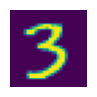

In [19]:
# Jupyter ships with a function called `show_image` that knows how to render a tensor as an image
show_image(three_tensors[1])

## rank-3 tensors

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. 

To do this we first combine all the images in this list into a single three-dimensional tensor. 

The most common way to describe such a tensor is to call it a _rank-3 tensor_.

See an example of what that might look like below:

![rank-3 tensor.png](./rank-3-tensor.png)

A rank-3 tensor is essentially a cube of numbers.

To index a number of that tensor, you would need:

- the layer
- the row
- the column

### how did we conclude that we needed a rank-3 tensor?

- Each image is a 2d matrix of pixels (rows and columns, e.g. a _rank-2 tensor_)
- Each element in the matrix corresponds to a pixel intensity (a scalar value, e.g. a _rank-1 tensor_)
- To ease computing of the average of each pixel intensity over all images, you would stack each of these matrices on top of each other: there you have it, a _rank-3 tensor_

In [20]:
# let's our images and cast our stacked tensors as float tensors for further computation
# we also normaliste our pixel values to be between 0 and 1 by dividing by 255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

# a _shape_ tells us the length of each axis of a tensor
stacked_threes.shape

torch.Size([6131, 28, 28])

The previous output says to us: "we have 6131 images, each of size 28x28 pixels". 

We can define the _shape_ as **the size of each axis in a tensor**.

In [22]:
# the _length_ of a tensor's shape is its _rank_
len(stacked_threes.shape)

3

In [23]:
# you could also get the rank of a tensor like so
stacked_threes.ndim

3

The _dimension_ 0 of our rank-3 tensor is the number of images.

Here is how you would compute the average pixel intensity for each pixel position:

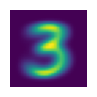

In [24]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

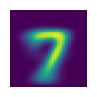

In [25]:
# let's do the same thing for the 7s
mean7 = stacked_sevens.mean(0)
show_image(mean7)

In [ ]:
# TODO rest of https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb